# LVV-T2190 Plots

This notebook is designed to query the EFD and make diagnostics plots for the execution of Test Case [LVV-T2190].  
This test case consists of applying `1 um` to the 7th component of the Annular Zernike Coefficient.  
Then it resets the corrections and applies `2 um` to the same component. 

This means that we can expect to have three values for each metric (at +1um, at 0um, and at +2um).  
We can expect that that each telemetry on the third row will be twice the values of the first row.  
If they are not, it can mean that the corrections are not properly calculated or that their relationship with the Zernike Coefficients are not linear.

When executing the tests, duplicate the notebook and rename it using the test execution name.

[LVV-T2190]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2190

In [ ]:
from lsst.ts import utils

# Extract your name from the Jupyter Hub
__executed_by__ = os.environ["JUPYTERHUB_USER"]  

# Extract execution date
__executed_on__ = utils.astropy_time_from_tai_unix(utils.current_tai())
__executed_on__.format = "isot"

# This is used later to define where Butler stores the images
summit = os.environ["LSST_DDS_PARTITION_PREFIX"] == "summit"

print(f"\nExecuted by {__executed_by__} on {__executed_on__}."
      f"\n  At the summit? {summit}")


Executed by hdrass on 2022-06-17T18:08:47.307.
  At the summit? True


## Set Up 

In [ ]:
import os 
import sys
import logging

import numpy as np
import pandas as pd

from astropy.time import Time
from astropy import units as u
from datetime import timedelta, datetime

import lsst_efd_client

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pandas.plotting import register_matplotlib_converters

In [ ]:
%config Application.log_level="ERROR"

In [ ]:
%matplotlib inline

## Time window for the test execution.

Update the cells below to reflect the time when the test was executed.  
This is the time window used to query the EFD.  

In [53]:
test_execution = "LVV-E1868"
time_start_utc = "2022-06-17T17:20:00.0"
time_end_utc = "2022-06-17T18:11:06.330"

#test_execution = "LVV-E1868"
#time_start_utc = "2022-05-13T17:06:00.000"
#time_end_utc = "2022-05-13T17:11:06.330"

# test_execution = "LVV-E1788"
# time_start_utc = "2022-04-08T14:20:42"
# time_end_utc = "2022-04-08T15:21:31"

In [54]:
start = Time(time_start_utc, format="isot", scale="utc")
end = Time(time_end_utc, format="isot", scale="utc")

## Initialization

We start by setting up a logger for the notebook and configuring the EFD Client.

In [55]:
log = logging.getLogger("LVV-T2190")
log.setLevel(logging.DEBUG)

In [56]:
lsst_efd_client.EfdClient.list_efd_names()

['tucson_teststand_efd',
 'test_efd',
 'summit_efd',
 'ncsa_teststand_efd',
 'ldf_stable_efd',
 'ldf_int_efd',
 'base_efd']

In [57]:
efd_name = "summit_efd"

In [58]:
client = lsst_efd_client.EfdClient(efd_name)

In [59]:
start.strftime("%m/%d/%Y, %H:%M:%S"), end.strftime("%m/%d/%Y, %H:%M:%S") 

('06/17/2022, 17:20:00', '06/17/2022, 18:11:06')

In [60]:
log.debug(f"{start.utc}, {end}")

In [61]:
os.makedirs("plots", exist_ok=True)

## Displaying results


### Display degrees of freedom

The degrees of freedom are the first step performed by the OFC in converting the wavefront errors into corrections. 

It is composed of two parts, the "aggregated" and the "visit" degrees of freedom.
The "aggregated" is the combination of all corrections computed so far whereas the "visit" contains only the degrees of freedom from the last correction.

These values are published as vectors of 50 elements each in the "degreeOfFreedom" event.
As with the `annularZernikeCoeff` case above we need to query them individually and then build the vectors afterwards.

In [62]:
degrees_of_freedom = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_degreeOfFreedom', 
    [f"aggregatedDoF{i}" for i in range(50)] + [f"visitDoF{i}" for i in range(50)], 
    start.utc, 
    end.utc
)

In [63]:
degrees_of_freedom

aggregatedDoF0  aggregatedDoF1  \
2022-06-17 18:01:45.998000+00:00        0.169121        0.054919   
2022-06-17 18:01:57.190000+00:00        0.216516        0.074500   
2022-06-17 18:01:57.751000+00:00        0.169121        0.054919   
2022-06-17 18:02:06.424000+00:00        0.216516        0.074500   
2022-06-17 18:02:12.143000+00:00        0.169121        0.054919   
2022-06-17 18:02:18.868000+00:00        0.385636        0.129420   
2022-06-17 18:03:56.573000+00:00        0.000000        0.000000   
2022-06-17 18:04:11.694000+00:00        0.000000        0.000000   
2022-06-17 18:07:15.282000+00:00        0.169121        0.054919   

                                  aggregatedDoF2  aggregatedDoF3  \
2022-06-17 18:01:45.998000+00:00      -71.852360      -11.856128   
2022-06-17 18:01:57.190000+00:00     -128.192546      -20.266218   
2022-06-17 18:01:57.751000+00:00      -71.852360      -11.856128   
2022-06-17 18:02:06.424000+00:00     -128.192546      -20.266218   
2022-06-17 18:02:12.143000+00:00      -71.852360      -11.856128   
2022-06-17 18:02:18.868000+00:00     -200.044907      -32.122346   
2022-06-17 18:03:56.573000+00:00        0.000000        0.000000   
2022-06-17 18:04:11.694000+00:00        0.000000        0.000000   
2022-06-17 18:07:15.282000+00:00      -71.852360      -11.856128   

                                  aggregatedDoF4  aggregatedDoF5  \
2022-06-17 18:01:45.998000+00:00       -0.008164        0.008265   
2022-06-17 18:01:57.190000+00:00       -0.012232        0.090462   
2022-06-17 18:01:57.751000+00:00       -0.008164        0.008265   
2022-06-17 18:02:06.424000+00:00       -0.012232        0.090462   
2022-06-17 18:02:12.143000+00:00       -0.008164        0.008265   
2022-06-17 18:02:18.868000+00:00       -0.020396        0.098726   
2022-06-17 18:03:56.573000+00:00        0.000000        0.000000   
2022-06-17 18:04:11.694000+00:00        0.000000        0.000000   
2022-06-17 18:07:15.282000+00:00       -0.008164        0.008265   

                                  aggregatedDoF6  aggregatedDoF7  \
2022-06-17 18:01:45.998000+00:00       -0.025150       37.968733   
2022-06-17 18:01:57.190000+00:00       -0.039064       62.612988   
2022-06-17 18:01:57.751000+00:00       -0.025150       37.968733   
2022-06-17 18:02:06.424000+00:00       -0.039064       62.612988   
2022-06-17 18:02:12.143000+00:00       -0.025150       37.968733   
2022-06-17 18:02:18.868000+00:00       -0.064214      100.581721   
2022-06-17 18:03:56.573000+00:00        0.000000        0.000000   
2022-06-17 18:04:11.694000+00:00        0.000000        0.000000   
2022-06-17 18:07:15.282000+00:00       -0.025150       37.968733   

                                  aggregatedDoF8  aggregatedDoF9  ...  \
2022-06-17 18:01:45.998000+00:00       -0.419880       -0.002405  ...   
2022-06-17 18:01:57.190000+00:00        0.018287       -0.002876  ...   
2022-06-17 18:01:57.751000+00:00       -0.419880       -0.002405  ...   
2022-06-17 18:02:06.424000+00:00        0.018287       -0.002876  ...   
2022-06-17 18:02:12.143000+00:00       -0.419880       -0.002405  ...   
2022-06-17 18:02:18.868000+00:00       -0.401594       -0.005281  ...   
2022-06-17 18:03:56.573000+00:00        0.000000        0.000000  ...   
2022-06-17 18:04:11.694000+00:00        0.000000        0.000000  ...   
2022-06-17 18:07:15.282000+00:00       -0.419880       -0.002405  ...   

                                  visitDoF40  visitDoF41  visitDoF42  \
2022-06-17 18:01:45.998000+00:00   -0.000021    0.000042    0.000041   
2022-06-17 18:01:57.190000+00:00   -0.000024   -0.000058    0.000039   
2022-06-17 18:01:57.751000+00:00   -0.000021    0.000042    0.000041   
2022-06-17 18:02:06.424000+00:00   -0.000024   -0.000058    0.000039   
2022-06-17 18:02:12.143000+00:00   -0.000021    0.000042    0.000041   
2022-06-17 18:02:18.868000+00:00   -0.000045   -0.000016    0.000080   
2022-06-17 18:03:56.573000+00:00    0.000000    0.000000    0.000000   
202

During the [LVV-T2190] test, we first issue an `1 um` aberration, reset the the corrections, and then issue a `2 um` aberration.  
Common sense says that row 2 and row 0 must have a factor of 2 of difference. 

In [64]:
degrees_of_freedom.iloc[2] / degrees_of_freedom.iloc[0]

aggregatedDoF0    1.0
aggregatedDoF1    1.0
aggregatedDoF2    1.0
aggregatedDoF3    1.0
aggregatedDoF4    1.0
                 ... 
visitDoF45        1.0
visitDoF46        1.0
visitDoF47        1.0
visitDoF48        1.0
visitDoF49        1.0
Length: 100, dtype: float64

We need to unpack the data from the EFD query into vectors that are easier to plot.

In [65]:
aggregated_dof = np.array([degrees_of_freedom[f"aggregatedDoF{i}"] for i in range(50)]).T
visit_dof = np.array([degrees_of_freedom[f"visitDoF{i}"] for i in range(50)]).T

In [66]:
comp_dof_idx = dict(
            m2HexPos=dict(
                startIdx=0,
                idxLength=5,
                state0name="M2Hexapod",
            ),
            camHexPos=dict(
                startIdx=5,
                idxLength=5,
                state0name="cameraHexapod",
            ),
            M1M3Bend=dict(
                startIdx=10, idxLength=20, state0name="M1M3Bending", rot_mat=1.0
            ),
            M2Bend=dict(startIdx=30, idxLength=20, state0name="M2Bending", rot_mat=1.0),
        )

And we finally plot them.

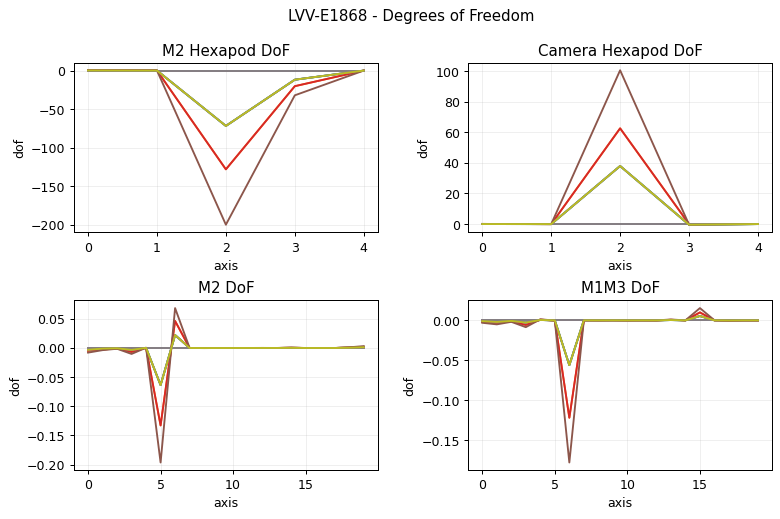

In [67]:
fig, axes = plt.subplots(2,2, figsize=(10,6), dpi=90)

for i in range(len(aggregated_dof)):
    
    axes[0][0].plot(
        aggregated_dof[i][
            comp_dof_idx["m2HexPos"]["startIdx"]:
            comp_dof_idx["m2HexPos"]["startIdx"]+comp_dof_idx["m2HexPos"]["idxLength"]
        ]
    )
    
    axes[0][1].plot(
        aggregated_dof[i][
            comp_dof_idx["camHexPos"]["startIdx"]:
            comp_dof_idx["camHexPos"]["startIdx"]+comp_dof_idx["camHexPos"]["idxLength"]
        ]
    )

    axes[1][0].plot(
        aggregated_dof[i][
            comp_dof_idx["M2Bend"]["startIdx"]:
            comp_dof_idx["M2Bend"]["startIdx"]+comp_dof_idx["M2Bend"]["idxLength"]
        ]
    )

    axes[1][1].plot(
        aggregated_dof[i][
            comp_dof_idx["M1M3Bend"]["startIdx"]:
            comp_dof_idx["M1M3Bend"]["startIdx"]+comp_dof_idx["M1M3Bend"]["idxLength"]
        ]
    )

ax_titles = ["M2 Hexapod DoF",  "Camera Hexapod DoF", "M2 DoF", "M1M3 DoF"]
for i in range(4):

    r = i // 2
    c = i % 2

    axes[r][c].set_title(ax_titles[i])
    axes[r][c].set_xlabel("axis")
    axes[r][c].set_ylabel("dof")
    axes[r][c].grid("-", alpha=0.2)

fig.suptitle(f"{test_execution} - Degrees of Freedom")
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.4, wspace=0.3)

fig.savefig(f"plots/{test_execution}_dof.png")

## Step 8

### Display Camera Hexapod Correction

In [68]:
cam_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["x", "y", "z"], 
    start.utc, 
    end.utc
)

cam_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["u", "v"], 
    start.utc, 
    end.utc
)

In [69]:
cam_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

cam_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

In [70]:
cam_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

cam_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

In [71]:
cam_hexapod_correction_computed_xyz

x           y         z
2022-06-17 18:01:46.006000+00:00  0.025150   37.968733 -0.008265
2022-06-17 18:01:57.191000+00:00  0.039064   62.612988 -0.090462
2022-06-17 18:02:06.425000+00:00  0.039064   62.612988 -0.090462
2022-06-17 18:02:12.144000+00:00  0.025150   37.968733 -0.008265
2022-06-17 18:02:18.918000+00:00  0.064214  100.581721 -0.098726
2022-06-17 18:03:56.574000+00:00  0.000000    0.000000  0.000000
2022-06-17 18:04:11.696000+00:00  0.000000    0.000000  0.000000
2022-06-17 18:07:15.292000+00:00  0.025150   37.968733 -0.008265

In [72]:
cam_hexapod_correction_computed_uv

u             v
2022-06-17 18:01:46.006000+00:00  0.000117  6.679176e-07
2022-06-17 18:01:57.191000+00:00 -0.000005  7.989896e-07
2022-06-17 18:02:06.425000+00:00 -0.000005  7.989896e-07
2022-06-17 18:02:12.144000+00:00  0.000117  6.679176e-07
2022-06-17 18:02:18.918000+00:00  0.000112  1.466907e-06
2022-06-17 18:03:56.574000+00:00  0.000000  0.000000e+00
2022-06-17 18:04:11.696000+00:00  0.000000  0.000000e+00
2022-06-17 18:07:15.292000+00:00  0.000117  6.679176e-07

In [73]:
cam_hexapod_correction_applied_xyz

x           y         z  MTHexapodID
2022-06-17 18:01:46.191000+00:00  0.025150   37.968733 -0.008265            1
2022-06-17 18:01:57.347000+00:00  0.039064   62.612988 -0.090462            1
2022-06-17 18:01:57.897000+00:00  0.025150   37.968733 -0.008265            1
2022-06-17 18:02:06.550000+00:00  0.039064   62.612988 -0.090462            1
2022-06-17 18:02:12.254000+00:00  0.025150   37.968733 -0.008265            1
2022-06-17 18:02:19.056000+00:00  0.064214  100.581721 -0.098726            1
2022-06-17 18:04:06.953000+00:00  0.000000    0.000000  0.000000            1
2022-06-17 18:07:27.591000+00:00  0.025150   37.968733 -0.008265            1

In [74]:
cam_hexapod_correction_applied_uv

u             v  MTHexapodID
2022-06-17 18:01:46.191000+00:00  0.000117  6.679176e-07            1
2022-06-17 18:01:57.347000+00:00 -0.000005  7.989896e-07            1
2022-06-17 18:01:57.897000+00:00  0.000117  6.679176e-07            1
2022-06-17 18:02:06.550000+00:00 -0.000005  7.989896e-07            1
2022-06-17 18:02:12.254000+00:00  0.000117  6.679176e-07            1
2022-06-17 18:02:19.056000+00:00  0.000112  1.466907e-06            1
2022-06-17 18:04:06.953000+00:00  0.000000  0.000000e+00            1
2022-06-17 18:07:27.591000+00:00  0.000117  6.679176e-07            1

In [75]:
cam_hexapod_correction_command_xyz

x           y         z  MTHexapodID
2022-06-17 18:01:00.298000+00:00  0.000000    0.000000  0.000000            1
2022-06-17 18:01:57.245000+00:00  0.039064   62.612988 -0.090462            1
2022-06-17 18:01:57.751000+00:00  0.025150   37.968733 -0.008265            1
2022-06-17 18:02:12.180000+00:00  0.025150   37.968733 -0.008265            1
2022-06-17 18:02:18.954000+00:00  0.064214  100.581721 -0.098726            1
2022-06-17 18:07:27.520000+00:00  0.025150   37.968733 -0.008265            1

In [76]:
cam_hexapod_correction_command_uv

u             v  MTHexapodID
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000e+00            1
2022-06-17 18:01:57.245000+00:00 -0.000005  7.989896e-07            1
2022-06-17 18:01:57.751000+00:00  0.000117  6.679176e-07            1
2022-06-17 18:02:12.180000+00:00  0.000117  6.679176e-07            1
2022-06-17 18:02:18.954000+00:00  0.000112  1.466907e-06            1
2022-06-17 18:07:27.520000+00:00  0.000117  6.679176e-07            1

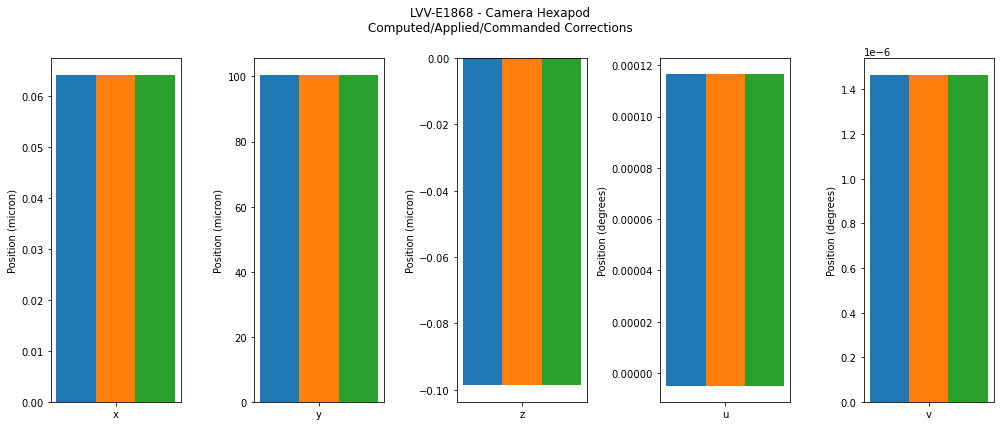

In [77]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=5)

for panel, label in enumerate("xyz"):

    ax = plt.subplot(1,5,panel+1)

    ax.bar(
        [-0.5],
        cam_hexapod_correction_computed_xyz[label],
        width=0.5
    )
    ax.bar(    
        [0.],
        cam_hexapod_correction_applied_xyz[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        cam_hexapod_correction_command_xyz[label],
        width=0.5
    )
    
    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (micron)")

for panel, label in enumerate("uv"):

    ax = plt.subplot(1,5,panel+4)
    
    x = [0.]

    b0 = ax.bar(
        [-0.5],
        cam_hexapod_correction_computed_uv[label],
        width=0.5,
    )
    
    b1 = ax.bar(    
        [0.],
        cam_hexapod_correction_applied_uv[label],
        width=0.5, 
    )

    b2 = ax.bar(    
        [0.5],
        cam_hexapod_correction_command_uv[label],
        width=0.5, 
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (degrees)")
    
fig.suptitle(f"{test_execution} - Camera Hexapod\nComputed/Applied/Commanded Corrections")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')

fig.savefig(f"plots/{test_execution}_camera_hexapod.png")

### Display M2 Hexapod Correction

In [78]:
m2_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["x", "y", "z"], 
    start.utc, 
    end.utc
)

m2_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["u", "v"], 
    start.utc, 
    end.utc
)

In [79]:
m2_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

In [80]:
m2_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

In [81]:
m2_hexapod_correction_command_xyz

x           y         z  MTHexapodID
2022-06-17 18:01:46.106000+00:00 -0.054919  -71.852360 -0.169121            2
2022-06-17 18:01:57.244000+00:00 -0.074500 -128.192546 -0.216516            2
2022-06-17 18:02:06.464000+00:00 -0.074500 -128.192546 -0.216516            2
2022-06-17 18:04:06.850000+00:00  0.000000    0.000000  0.000000            2
2022-06-17 18:07:27.519000+00:00 -0.054919  -71.852360 -0.169121            2

In [82]:
m2_hexapod_correction_computed_xyz

x           y         z
2022-06-17 18:01:45.999000+00:00 -0.054919  -71.852360 -0.169121
2022-06-17 18:01:57.190000+00:00 -0.074500 -128.192546 -0.216516
2022-06-17 18:02:06.425000+00:00 -0.074500 -128.192546 -0.216516
2022-06-17 18:02:12.144000+00:00 -0.054919  -71.852360 -0.169121
2022-06-17 18:02:18.869000+00:00 -0.129420 -200.044907 -0.385636
2022-06-17 18:03:56.573000+00:00  0.000000    0.000000  0.000000
2022-06-17 18:04:11.695000+00:00  0.000000    0.000000  0.000000
2022-06-17 18:07:15.283000+00:00 -0.054919  -71.852360 -0.169121

In [83]:
m2_hexapod_correction_applied_xyz

x           y         z  MTHexapodID
2022-06-17 18:01:46.108000+00:00 -0.054919  -71.852360 -0.169121            2
2022-06-17 18:02:06.466000+00:00 -0.074500 -128.192546 -0.216516            2
2022-06-17 18:02:12.181000+00:00 -0.054919  -71.852360 -0.169121            2
2022-06-17 18:02:18.955000+00:00 -0.129420 -200.044907 -0.385636            2
2022-06-17 18:04:06.852000+00:00  0.000000    0.000000  0.000000            2
2022-06-17 18:07:27.521000+00:00 -0.054919  -71.852360 -0.169121            2

In [84]:
m2_hexapod_correction_command_uv

u         v  MTHexapodID
2022-06-17 18:01:46.106000+00:00  0.003293  0.000002            2
2022-06-17 18:01:57.244000+00:00  0.005630  0.000003            2
2022-06-17 18:02:06.464000+00:00  0.005630  0.000003            2
2022-06-17 18:04:06.850000+00:00  0.000000  0.000000            2
2022-06-17 18:07:27.519000+00:00  0.003293  0.000002            2

In [85]:
m2_hexapod_correction_computed_uv

u         v
2022-06-17 18:01:45.999000+00:00  0.003293  0.000002
2022-06-17 18:01:57.190000+00:00  0.005630  0.000003
2022-06-17 18:02:06.425000+00:00  0.005630  0.000003
2022-06-17 18:02:12.144000+00:00  0.003293  0.000002
2022-06-17 18:02:18.869000+00:00  0.008923  0.000006
2022-06-17 18:03:56.573000+00:00  0.000000  0.000000
2022-06-17 18:04:11.695000+00:00  0.000000  0.000000
2022-06-17 18:07:15.283000+00:00  0.003293  0.000002

In [86]:
m2_hexapod_correction_applied_uv

u         v  MTHexapodID
2022-06-17 18:01:46.108000+00:00  0.003293  0.000002            2
2022-06-17 18:02:06.466000+00:00  0.005630  0.000003            2
2022-06-17 18:02:12.181000+00:00  0.003293  0.000002            2
2022-06-17 18:02:18.955000+00:00  0.008923  0.000006            2
2022-06-17 18:04:06.852000+00:00  0.000000  0.000000            2
2022-06-17 18:07:27.521000+00:00  0.003293  0.000002            2

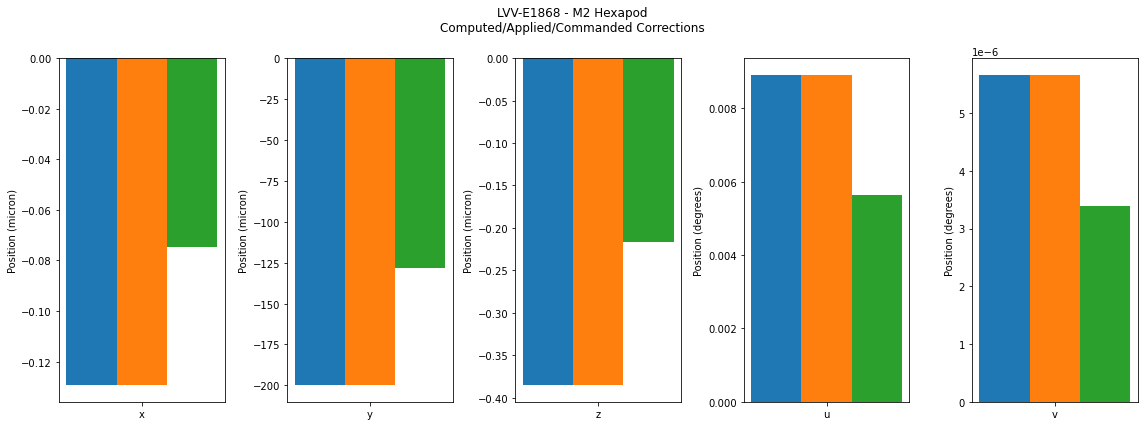

In [87]:
fig, axs = plt.subplots(figsize=(16, 6), ncols=5)

for panel, label in enumerate("xyz"):

    ax = axs[panel]
    
    ax.bar(
        [-0.5],
        m2_hexapod_correction_computed_xyz[label],
        width=0.5
    )
    
    ax.bar(    
        [0.],
        m2_hexapod_correction_applied_xyz[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        m2_hexapod_correction_command_xyz[label],
        width=0.5
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (micron)")

    
for panel, label in enumerate("uv"):

    ax = axs[panel + 3]
    
    ax.bar(
        [-0.5],
        m2_hexapod_correction_computed_uv[label],
        width=0.5
    )
    
    ax.bar(    
        [0.],
        m2_hexapod_correction_applied_uv[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        m2_hexapod_correction_command_uv[label],
        width=0.5
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (degrees)")


fig.suptitle(f"{test_execution} - M2 Hexapod\nComputed/Applied/Commanded Corrections")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')

fig.savefig(f"plots/{test_execution}_m2_hexapod.png")

### Display M2 Correction

In [88]:
m2_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2Correction', 
    [f"zForces{i}" for i in range(72)], 
    start.utc, 
    end.utc
)

In [89]:
m2_correction

zForces0  zForces1  zForces2  zForces3  \
2022-06-17 18:01:46.008000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   
2022-06-17 18:01:57.192000+00:00 -1.484869 -1.450552 -1.375108 -1.229742   
2022-06-17 18:02:06.427000+00:00 -1.484869 -1.450552 -1.375108 -1.229742   
2022-06-17 18:02:12.145000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   
2022-06-17 18:02:18.919000+00:00 -2.244057 -2.191770 -2.079476 -1.859924   
2022-06-17 18:03:56.575000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:04:11.697000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:07:15.293000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   

                                  zForces4  zForces5  zForces6  zForces7  \
2022-06-17 18:01:46.008000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   
2022-06-17 18:01:57.192000+00:00 -1.015420 -0.767578 -0.476014 -0.158691   
2022-06-17 18:02:06.427000+00:00 -1.015420 -0.767578 -0.476014 -0.158691   
2022-06-17 18:02:12.145000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   
2022-06-17 18:02:18.919000+00:00 -1.533687 -1.157800 -0.716226 -0.237711   
2022-06-17 18:03:56.575000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:04:11.697000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:07:15.293000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   

                                  zForces8  zForces9  ...  zForces62  \
2022-06-17 18:01:46.008000+00:00  0.083761  0.241742  ...  -0.776518   
2022-06-17 18:01:57.192000+00:00  0.164762  0.477563  ...  -1.799385   
2022-06-17 18:02:06.427000+00:00  0.164762  0.477563  ...  -1.799385   
2022-06-17 18:02:12.145000+00:00  0.083761  0.241742  ...  -0.776518   
2022-06-17 18:02:18.919000+00:00  0.248523  0.719305  ...  -2.575903   
2022-06-17 18:03:56.575000+00:00  0.000000  0.000000  ...   0.000000   
2022-06-17 18:04:11.697000+00:00  0.000000  0.000000  ...   0.000000   
2022-06-17 18:07:15.293000+00:00  0.083761  0.241742  ...  -0.776518   

                                  zForces63  zForces64  zForces65  zForces66  \
2022-06-17 18:01:46.008000+00:00  -0.843476  -0.782143  -0.612518  -0.391572   
2022-06-17 18:01:57.192000+00:00  -1.939438  -1.806488  -1.430485  -0.913980   
2022-06-17 18:02:06.427000+00:00  -1.939438  -1.806488  -1.430485  -0.913980   
2022-06-17 18:02:12.145000+00:00  -0.843476  -0.782143  -0.612518  -0.391572   
2022-06-17 18:02:18.919000+00:00  -2.782914  -2.588631  -2.043003  -1.305551   
2022-06-17 18:03:56.575000+00:00   0.000000   0.000000   0.000000   0.000000   
2022-06-17 18:04:11.697000+00:00   0.000000   0.000000   0.000000   0.000000   
2022-06-17 18:07:15.293000+00:00  -0.843476  -0.782143  -0.612518  -0.391572   

                                  zForces67  zForces68  zForces69  zForces70  \
2022-06-17 18:01:46.008000+00:00  -0.138743   0.136610   0.387046   0.604225   
2022-06-17 18:01:57.192000+00:00  -0.318616   0.318486   0.910369   1.421071   
2022-06-17 18:02:06.427000+00:00  -0.318616   0.318486   0.910369   1.421071   
2022-06-17 18:02:12.145000+00:00  -0.138743   0.136610   0.387046   0.604225   
2022-06-17 18:02:18.919000+00:00  -0.457359   0.455096   1.297415   2.025296   
2022-06-17 18:03:56.575000+00:00   0.000000   0.000000   0.000000   0.000000   
2022-06-17 18:04:11.697000+00:00   0.000000   0.000000   0.000000   0.000000   
2022-06-17 18:07:15.293000+00:00  -0.138743   0.136610   0.387046   0.604225   

                                  zForces71  
2022-06-17 18:01:46.008000+00:00   0.773663  
2022-06-17 18:01:57.192000+00:00   1.795960  
2022-06-17 18:02:06.427000+00:00   1.795960  
2022-06-17 18:02:12.145000+00:00   0.773663  
2022-06-17 18:02:18.919000+00:00   2.569623  
2022-06-17 18:03:56.575000+00:00   0.000000  
2022-06-17 18:04:11.697000+00:00   0.000000  
2022-06-17 18:07:15.293000+00:00   0.773663  

[8 rows x 72 columns]

In [90]:
m2_correction_applied = await client.select_time_series(
    'lsst.sal.MTM2.command_applyForces', 
    [f"axial{i}" for i in range(72)], 
    start.utc, 
    end.utc
)

In [91]:
m2_correction_applied

axial0    axial1    axial2    axial3  \
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:01:46.106000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   
2022-06-17 18:01:57.245000+00:00 -1.484869 -1.450552 -1.375108 -1.229742   
2022-06-17 18:01:57.898000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   
2022-06-17 18:02:06.464000+00:00 -1.484869 -1.450552 -1.375108 -1.229742   
2022-06-17 18:02:12.180000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   
2022-06-17 18:02:18.954000+00:00 -2.244057 -2.191770 -2.079476 -1.859924   
2022-06-17 18:04:06.851000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:07:27.520000+00:00 -0.759188 -0.741219 -0.704368 -0.630182   

                                    axial4    axial5    axial6    axial7  \
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:01:46.106000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   
2022-06-17 18:01:57.245000+00:00 -1.015420 -0.767578 -0.476014 -0.158691   
2022-06-17 18:01:57.898000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   
2022-06-17 18:02:06.464000+00:00 -1.015420 -0.767578 -0.476014 -0.158691   
2022-06-17 18:02:12.180000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   
2022-06-17 18:02:18.954000+00:00 -1.533687 -1.157800 -0.716226 -0.237711   
2022-06-17 18:04:06.851000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:07:27.520000+00:00 -0.518267 -0.390221 -0.240212 -0.079020   

                                    axial8    axial9  ...   axial62   axial63  \
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000  ...  0.000000  0.000000   
2022-06-17 18:01:46.106000+00:00  0.083761  0.241742  ... -0.776518 -0.843476   
2022-06-17 18:01:57.245000+00:00  0.164762  0.477563  ... -1.799385 -1.939438   
2022-06-17 18:01:57.898000+00:00  0.083761  0.241742  ... -0.776518 -0.843476   
2022-06-17 18:02:06.464000+00:00  0.164762  0.477563  ... -1.799385 -1.939438   
2022-06-17 18:02:12.180000+00:00  0.083761  0.241742  ... -0.776518 -0.843476   
2022-06-17 18:02:18.954000+00:00  0.248523  0.719305  ... -2.575903 -2.782914   
2022-06-17 18:04:06.851000+00:00  0.000000  0.000000  ...  0.000000  0.000000   
2022-06-17 18:07:27.520000+00:00  0.083761  0.241742  ... -0.776518 -0.843476   

                                   axial64   axial65   axial66   axial67  \
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:01:46.106000+00:00 -0.782143 -0.612518 -0.391572 -0.138743   
2022-06-17 18:01:57.245000+00:00 -1.806488 -1.430485 -0.913980 -0.318616   
2022-06-17 18:01:57.898000+00:00 -0.782143 -0.612518 -0.391572 -0.138743   
2022-06-17 18:02:06.464000+00:00 -1.806488 -1.430485 -0.913980 -0.318616   
2022-06-17 18:02:12.180000+00:00 -0.782143 -0.612518 -0.391572 -0.138743   
2022-06-17 18:02:18.954000+00:00 -2.588631 -2.043003 -1.305551 -0.457359   
2022-06-17 18:04:06.851000+00:00  0.000000  0.000000  0.000000  0.000000   
2022-06-17 18:07:27.520000+00:00 -0.782143 -0.612518 -0.391572 -0.138743   

                                   axial68   axial69   axial70   axial71  
2022-06-17 18:01:00.298000+00:00  0.000000  0.000000  0.000000  0.000000  
2022-06-17 18:01:46.106000+00:00  0.136610  0.387046  0.604225  0.773663  
2022-06-17 18:01:57.245000+00:00  0.318486  0.910369  1.421071  1.795960  
2022-06-17 18:01:57.898000+00:00  0.136610  0.387046  0.604225  0.773663  
2022-06-17 18:02:06.464000+00:00  0.318486  0.910369  1.421071  1.795960  
2022-06-17 18:02:12.180000+00:00  0.136610  0.387046  0.604225  0.773663  
2022-06-17 18:02:18.954000+00:00  0.455096  1.297415  2.025296  2.569623  
2022-06-17 18:04:06.851000+00:00  0.000000  0.000000  0.000000  0.000000  
2022-06-17 18:07:27.520000+00:00  0.136610  0.387046  0.604225  0.773663  

[9 rows x 72 columns]

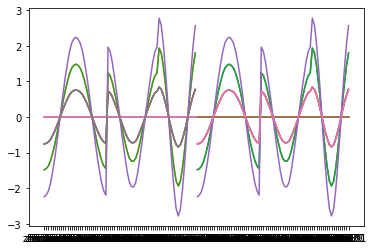

In [92]:
plt.plot(m2_correction.T)
plt.plot(m2_correction_applied.T)

In [93]:
aa = np.loadtxt('%s/notebooks/M2_FEA/data/M2_1um_72_force.txt'%(os.environ["HOME"]))
# to have +x going to right, and +y going up, we need to transpose and reverse x and y
m2_xact = -aa[:,2]
m2_yact = -aa[:,1]

In [94]:
m2_yact

array([-1.333500e-16, -3.328670e-01, -6.511849e-01, -9.410446e-01,
       -1.189774e+00, -1.386507e+00, -1.522641e+00, -1.592229e+00,
       -1.592229e+00, -1.522641e+00, -1.386507e+00, -1.189774e+00,
       -9.410446e-01, -6.511849e-01, -3.328670e-01,  0.000000e+00,
        3.328670e-01,  6.511849e-01,  9.410446e-01,  1.189774e+00,
        1.386507e+00,  1.522641e+00,  1.592229e+00,  1.592229e+00,
        1.522641e+00,  1.386507e+00,  1.189774e+00,  9.410446e-01,
        6.511849e-01,  3.328670e-01, -1.675856e-01, -4.913528e-01,
       -7.816342e-01, -1.018647e+00, -1.186244e+00, -1.272997e+00,
       -1.273000e+00, -1.186249e+00, -1.018657e+00, -7.816469e-01,
       -4.913655e-01, -1.676011e-01,  1.675856e-01,  4.913528e-01,
        7.816342e-01,  1.018647e+00,  1.186244e+00,  1.272997e+00,
        1.273000e+00,  1.186249e+00,  1.018657e+00,  7.816469e-01,
        4.913655e-01,  1.676011e-01,  3.893820e-16, -3.427044e-01,
       -6.440729e-01, -8.677580e-01, -9.867773e-01, -9.867773e

In [95]:
aa = np.array(m2_correction.T)

In [ ]:
aa.shape

In [ ]:
m2_correction.T

In [ ]:
m2_correction_applied.T

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14,6))


for panel, timestamp in enumerate(m2_correction_applied.index):
    
    img = axes[panel].scatter(
        m2_xact, 
        m2_yact, 
        c=m2_correction_applied.T[timestamp], 
        s=200, 
        vmin=-1.5, 
        vmax=1.5
    )

    axes[panel].axis('equal')

axes[0].set_title("+1um")
axes[1].set_title("zero")
axes[2].set_title("+2um")

fig.patch.set_facecolor('white')
fig.suptitle(f"{test_execution} - Step 8\nM2 Corrections", x=0.435)
fig.tight_layout()
fig.colorbar(img, ax=axes, label="Correction [um]", pad=0.01)

fig.savefig(f"plots/{test_execution}_m2.png")

### Display M1M3 Correction

In [ ]:
FATABLE_XPOSITION = 2
FATABLE_YPOSITION = 3

FATABLE = np.array([
    [0,101,0.776782776,0,-2.158743,'SAA',3,1,'NA',-1,-1,0,-1],
    [1,102,1.442567993,0,-2.158743,'DAA',1,17,'+Y',-1,0,1,0],
    [2,103,2.10837793,0,-2.158743,'DAA',4,17,'+Y',-1,1,2,1],
    [3,104,2.774187988,0,-2.158743,'DAA',2,17,'+Y',-1,2,3,2],
    [4,105,3.439998047,0,-2.158743,'DAA',3,17,'+Y',-1,3,4,3],
    [5,106,3.968012939,0,-2.158743,'SAA',2,1,'NA',-1,-1,5,-1],
    [6,107,0.44386499,-0.57660498,-2.158743,'SAA',1,1,'NA',-1,-1,6,-1],
    [7,108,1.109675049,-0.57660498,-2.158743,'DAA',4,18,'+Y',-1,4,7,4],
    [8,109,1.775484985,-0.57660498,-2.158743,'DAA',2,18,'+Y',-1,5,8,5],
    [9,110,2.441295898,-0.57660498,-2.158743,'DAA',3,18,'+Y',-1,6,9,6],
    [10,111,3.107080078,-0.57660498,-2.158743,'DAA',1,18,'+Y',-1,7,10,7],
    [11,112,3.772891113,-0.57660498,-2.158743,'DAA',4,19,'-X',0,-1,11,8],
    [12,113,0,-1.153209961,-2.158743,'DAA',2,19,'+Y',-1,8,12,9],
    [13,114,0.776782776,-1.153209961,-2.158743,'DAA',3,19,'+Y',-1,9,13,10],
    [14,115,1.442567993,-1.153209961,-2.158743,'DAA',1,19,'+Y',-1,10,14,11],
    [15,116,2.10837793,-1.153209961,-2.158743,'DAA',4,20,'+Y',-1,11,15,12],
    [16,117,2.774187988,-1.153209961,-2.158743,'DAA',2,20,'+Y',-1,12,16,13],
    [17,118,3.439998047,-1.153209961,-2.158743,'DAA',3,20,'+Y',-1,13,17,14],
    [18,119,3.9005,-0.997687012,-2.158743,'SAA',2,2,'NA',-1,-1,18,-1],
    [19,120,0.44386499,-1.729819946,-2.158743,'DAA',1,20,'+Y',-1,14,19,15],
    [20,121,1.109675049,-1.729819946,-2.158743,'DAA',4,21,'+Y',-1,15,20,16],
    [21,122,1.775484985,-1.729819946,-2.158743,'DAA',2,21,'+Y',-1,16,21,17],
    [22,123,2.44127002,-1.729819946,-2.158743,'DAA',3,21,'+Y',-1,17,22,18],
    [23,124,3.107080078,-1.729819946,-2.158743,'DAA',1,21,'+Y',-1,18,23,19],
    [24,125,3.724452881,-1.517949951,-2.158743,'SAA',4,1,'NA',-1,-1,24,-1],
    [25,126,0,-2.306419922,-2.158743,'DAA',2,22,'+Y',-1,19,25,20],
    [26,127,0.776782776,-2.306419922,-2.158743,'DAA',3,22,'+Y',-1,20,26,21],
    [27,128,1.442567993,-2.306419922,-2.158743,'DAA',1,22,'-X',1,-1,27,22],
    [28,129,2.10837793,-2.306419922,-2.158743,'DAA',4,22,'+Y',-1,21,28,23],
    [29,130,2.774187988,-2.306419922,-2.158743,'DAA',2,23,'+Y',-1,22,29,24],
    [30,131,3.387954102,-2.167409912,-2.158743,'SAA',3,2,'NA',-1,-1,30,-1],
    [31,132,0.44386499,-2.883030029,-2.158743,'DAA',1,23,'+Y',-1,23,31,25],
    [32,133,1.109675049,-2.883030029,-2.158743,'DAA',4,23,'+Y',-1,24,32,26],
    [33,134,1.775484985,-2.883030029,-2.158743,'DAA',2,24,'+Y',-1,25,33,27],
    [34,135,2.44127002,-2.883030029,-2.158743,'DAA',3,23,'-X',2,-1,34,28],
    [35,136,2.939364014,-2.745179932,-2.158743,'SAA',4,2,'NA',-1,-1,35,-1],
    [36,137,0.221945206,-3.459629883,-2.158743,'DAA',2,25,'+Y',-1,26,36,29],
    [37,138,0.88772998,-3.459629883,-2.158743,'DAA',3,24,'+Y',-1,27,37,30],
    [38,139,1.553540039,-3.267429932,-2.158743,'SAA',1,2,'NA',-1,-1,38,-1],
    [39,140,2.089733887,-3.436389893,-2.158743,'SAA',4,3,'NA',-1,-1,39,-1],
    [40,141,0.365734589,-4.00525,-2.158743,'SAA',1,3,'NA',-1,-1,40,-1],
    [41,142,1.085088013,-3.87276001,-2.158743,'SAA',2,3,'NA',-1,-1,41,-1],
    [42,143,1.60401001,-3.692780029,-2.158743,'SAA',3,3,'NA',-1,-1,42,-1],
    [43,207,-0.44386499,-0.57660498,-2.158743,'SAA',1,4,'NA',-1,-1,43,-1],
    [44,208,-1.109680054,-0.57660498,-2.158743,'DAA',4,24,'+Y',-1,28,44,31],
    [45,209,-1.77548999,-0.57660498,-2.158743,'DAA',2,26,'+Y',-1,29,45,32],
    [46,210,-2.441300049,-0.57660498,-2.158743,'DAA',3,25,'+Y',-1,30,46,33],
    [47,211,-3.107080078,-0.57660498,-2.158743,'DAA',1,24,'+Y',-1,31,47,34],
    [48,212,-3.772889893,-0.57660498,-2.158743,'DAA',4,25,'+X',3,-1,48,35],
    [49,214,-0.77678302,-1.153209961,-2.158743,'DAA',3,26,'+Y',-1,32,49,36],
    [50,215,-1.442569946,-1.153209961,-2.158743,'DAA',1,25,'+Y',-1,33,50,37],
    [51,216,-2.108379883,-1.153209961,-2.158743,'DAA',4,26,'+Y',-1,34,51,38],
    [52,217,-2.774189941,-1.153209961,-2.158743,'DAA',2,27,'+Y',-1,35,52,39],
    [53,218,-3.44,-1.153209961,-2.158743,'DAA',3,27,'+Y',-1,36,53,40],
    [54,219,-3.9005,-0.997687012,-2.158743,'SAA',2,4,'NA',-1,-1,54,-1],
    [55,220,-0.44386499,-1.729819946,-2.158743,'DAA',1,26,'+Y',-1,37,55,41],
    [56,221,-1.109680054,-1.729819946,-2.158743,'DAA',4,27,'+Y',-1,38,56,42],
    [57,222,-1.77548999,-1.729819946,-2.158743,'DAA',2,28,'+Y',-1,39,57,43],
    [58,223,-2.44127002,-1.729819946,-2.158743,'DAA',3,28,'+Y',-1,40,58,44],
    [59,224,-3.107080078,-1.729819946,-2.158743,'DAA',1,27,'+Y',-1,41,59,45],
    [60,225,-3.724449951,-1.517949951,-2.158743,'SAA',4,4,'NA',-1,-1,60,-1],
    [61,227,-0.77678302,-2.306419922,-2.158743,'DAA',3,29,'+Y',-1,42,61,46],
    [62,228,-1.442569946,-2.306419922,-2.158743,'DAA',1,28,'+X',4,-1,62,47],
    [63,229,-2.108379883,-2.306419922,-2.158743,'DAA',4,28,'+Y',-1,43,63,48],
    [64,230,-2.774189941,-2.306419922,-2.158743,'DAA',2,29,'+Y',-1,44,64,49],
    [65,231,-3.387949951,-2.167409912,-2.158743,'SAA',3,4,'NA',-1,-1,65,-1],
    [66,232,-0.44386499,-2.883030029,-2.158743,'DAA',1,29,'+Y',-1,45,66,50],
    [67,233,-1.109680054,-2.883030029,-2.158743,'DAA',4,29,'+Y',-1,46,67,51],
    [68,234,-1.77548999,-2.883030029,-2.158743,'DAA',2,30,'+Y',-1,47,68,52],
    [69,235,-2.44127002,-2.883030029,-2.158743,'DAA',3,30,'+X',5,-1,69,53],
    [70,236,-2.939360107,-2.745179932,-2.158743,'SAA',4,5,'NA',-1,-1,70,-1],
    [71,237,-0.221945007,-3.459629883,-2.158743,'DAA',2,31,'+Y',-1,48,71,54],
    [72,238,-0.88772998,-3.459629883,-2.158743,'DAA',3,31,'+Y',-1,49,72,55],
    [73,239,-1.553540039,-3.267429932,-2.158743,'SAA',1,5,'NA',-1,-1,73,-1],
    [74,240,-2.08972998,-3.436389893,-2.158743,'SAA',4,6,'NA',-1,-1,74,-1],
    [75,241,-0.365734985,-4.00525,-2.158743,'SAA',1,6,'NA',-1,-1,75,-1],
    [76,242,-1.085089966,-3.87276001,-2.158743,'SAA',2,5,'NA',-1,-1,76,-1],
    [77,243,-1.60401001,-3.692780029,-2.158743,'SAA',3,5,'NA',-1,-1,77,-1],
    [78,301,-0.77678302,0,-2.158743,'SAA',3,6,'NA',-1,-1,78,-1],
    [79,302,-1.442569946,0,-2.158743,'DAA',1,30,'+Y',-1,50,79,56],
    [80,303,-2.108379883,0,-2.158743,'DAA',4,30,'+Y',-1,51,80,57],
    [81,304,-2.774189941,0,-2.158743,'DAA',2,32,'+Y',-1,52,81,58],
    [82,305,-3.44,0,-2.158743,'DAA',3,32,'+Y',-1,53,82,59],
    [83,306,-3.96801001,0,-2.158743,'SAA',2,6,'NA',-1,-1,83,-1],
    [84,307,-0.44386499,0.576605408,-2.158743,'SAA',1,7,'NA',-1,-1,84,-1],
    [85,308,-1.109680054,0.576605408,-2.158743,'DAA',4,31,'+Y',-1,54,85,60],
    [86,309,-1.77548999,0.576605408,-2.158743,'DAA',2,33,'+Y',-1,55,86,61],
    [87,310,-2.441300049,0.576605408,-2.158743,'DAA',3,33,'+Y',-1,56,87,62],
    [88,311,-3.107080078,0.576605408,-2.158743,'DAA',1,31,'-Y',-1,57,88,63],
    [89,312,-3.772889893,0.576605408,-2.158743,'DAA',4,32,'+X',6,-1,89,64],
    [90,313,0,1.15321106,-2.158743,'DAA',2,34,'+Y',-1,58,90,65],
    [91,314,-0.77678302,1.15321106,-2.158743,'DAA',3,34,'+Y',-1,59,91,66],
    [92,315,-1.442569946,1.15321106,-2.158743,'DAA',1,32,'+Y',-1,60,92,67],
    [93,316,-2.108379883,1.15321106,-2.158743,'DAA',4,33,'+Y',-1,61,93,68],
    [94,317,-2.774189941,1.15321106,-2.158743,'DAA',2,35,'+Y',-1,62,94,69],
    [95,318,-3.44,1.15321106,-2.158743,'DAA',3,35,'+Y',-1,63,95,70],
    [96,319,-3.9005,0.997686584,-2.158743,'SAA',2,7,'NA',-1,-1,96,-1],
    [97,320,-0.44386499,1.72981604,-2.158743,'DAA',1,33,'+Y',-1,64,97,71],
    [98,321,-1.109680054,1.72981604,-2.158743,'DAA',4,34,'+Y',-1,65,98,72],
    [99,322,-1.77548999,1.72981604,-2.158743,'DAA',2,36,'+Y',-1,66,99,73],
    [100,323,-2.44127002,1.72981604,-2.158743,'DAA',3,36,'+Y',-1,67,100,74],
    [101,324,-3.107080078,1.72981604,-2.158743,'DAA',1,34,'+Y',-1,68,101,75],
    [102,325,-3.724449951,1.517954956,-2.158743,'SAA',4,7,'NA',-1,-1,102,-1],
    [103,326,0,2.306422119,-2.158743,'DAA',2,37,'+Y',-1,69,103,76],
    [104,327,-0.77678302,2.306422119,-2.158743,'DAA',3,37,'+Y',-1,70,104,77],
    [105,328,-1.442569946,2.306422119,-2.158743,'DAA',1,35,'+X',7,-1,105,78],
    [106,329,-2.108379883,2.306422119,-2.158743,'DAA',4,35,'+Y',-1,71,106,79],
    [107,330,-2.774189941,2.306422119,-2.158743,'DAA',2,38,'+Y',-1,72,107,80],
    [108,331,-3.387949951,2.167406982,-2.158743,'SAA',3,7,'NA',-1,-1,108,-1],
    [109,332,-0.44386499,2.8830271,-2.158743,'DAA',1,36,'+Y',-1,73,109,81],
    [110,333,-1.109680054,2.8830271,-2.158743,'DAA',4,36,'+Y',-1,74,110,82],
    [111,334,-1.77548999,2.8830271,-2.158743,'DAA',2,39,'-Y',-1,75,111,83],
    [112,335,-2.44127002,2.8830271,-2.158743,'DAA',3,38,'+X',8,-1,112,84],
    [113,336,-2.939360107,2.745180908,-2.158743,'SAA',4,8,'NA',-1,-1,113,-1],
    [114,337,-0.221945007,3.45963208,-2.158743,'DAA',2,40,'+Y',-1,76,114,85],
    [115,338,-0.88772998,3.45963208,-2.158743,'DAA',3,39,'+Y',-1,77,115,86],
    [116,339,-1.553540039,3.267430908,-2.158743,'SAA',1,8,'NA',-1,-1,116,-1],
    [117,340,-2.08972998,3.436391113,-2.158743,'SAA',4,9,'NA',-1,-1,117,-1],
    [118,341,-0.365734985,4.00525,-2.158743,'SAA',1,9,'NA',-1,-1,118,-1],
    [119,342,-1.085089966,3.872762939,-2.158743,'SAA',2,8,'NA',-1,-1,119,-1],
    [120,343,-1.60401001,3.692779053,-2.158743,'SAA',3,8,'NA',-1,-1,120,-1],
    [121,407,0.44386499,0.576605408,-2.158743,'SAA',1,10,'NA',-1,-1,121,-1],
    [122,408,1.109675049,0.576605408,-2.158743,'DAA',4,37,'+Y',-1,78,122,87],
    [123,409,1.775484985,0.576605408,-2.158743,'DAA',2,41,'+Y',-1,79,123,88],
    [124,410,2.441295898,0.576605408,-2.158743,'DAA',3,40,'+Y',-1,80,124,89],
    [125,411,3.107080078,0.576605408,-2.158743,'DAA',1,37,'-Y',-1,81,125,90],
    [126,412,3.772891113,0.576605408,-2.158743,'DAA',4,38,'-X',9,-1,126,91],
    [127,414,0.776782776,1.15321106,-2.158743,'DAA',3,41,'+Y',-1,82,127,92],
    [128,415,1.442567993,1.15321106,-2.158743,'DAA',1,38,'+Y',-1,83,128,93],
    [129,416,2.10837793,1.15321106,-2.158743,'DAA',4,39,'+Y',-1,84,129,94],
    [130,417,2.774187988,1.15321106,-2.158743,'DAA',2,42,'+Y',-1,85,130,95],
    [131,418,3.439998047,1.15321106,-2.158743,'DAA',3,42,'+Y',-1,86,131,96],
    [132,419,3.9005,0.997686584,-2.158743,'SAA',2,9,'NA',-1,-1,132,-1],
    [133,420,0.44386499,1.72981604,-2.158743,'DAA',1,39,'+Y',-1,87,133,97],
    [134,421,1.109675049,1.72981604,-2.158743,'DAA',4,40,'+Y',-1,88,134,98],
    [135,422,1.775484985,1.72981604,-2.158743,'DAA',2,43,'+Y',-1,89,135,99],
    [136,423,2.44127002,1.72981604,-2.158743,'DAA',3,43,'+Y',-1,90,136,100],
    [137,424,3.107080078,1.72981604,-2.158743,'DAA',1,40,'+Y',-1,91,137,101],
    [138,425,3.724452881,1.517954956,-2.158743,'SAA',4,10,'NA',-1,-1,138,-1],
    [139,427,0.776782776,2.306422119,-2.158743,'DAA',3,44,'+Y',-1,92,139,102],
    [140,428,1.442567993,2.306422119,-2.158743,'DAA',1,41,'-X',10,-1,140,103],
    [141,429,2.10837793,2.306422119,-2.158743,'DAA',4,41,'+Y',-1,93,141,104],
    [142,430,2.774187988,2.306422119,-2.158743,'DAA',2,44,'+Y',-1,94,142,105],
    [143,431,3.387954102,2.167406982,-2.158743,'SAA',3,9,'NA',-1,-1,143,-1],
    [144,432,0.44386499,2.8830271,-2.158743,'DAA',1,42,'+Y',-1,95,144,106],
    [145,433,1.109675049,2.8830271,-2.158743,'DAA',4,42,'+Y',-1,96,145,107],
    [146,434,1.775484985,2.8830271,-2.158743,'DAA',2,45,'-Y',-1,97,146,108],
    [147,435,2.44127002,2.8830271,-2.158743,'DAA',3,45,'-X',11,-1,147,109],
    [148,436,2.939364014,2.745180908,-2.158743,'SAA',4,11,'NA',-1,-1,148,-1],
    [149,437,0.221945206,3.45963208,-2.158743,'DAA',2,46,'+Y',-1,98,149,110],
    [150,438,0.88772998,3.45963208,-2.158743,'DAA',3,46,'+Y',-1,99,150,111],
    [151,439,1.553540039,3.267430908,-2.158743,'SAA',1,11,'NA',-1,-1,151,-1],
    [152,440,2.089733887,3.436391113,-2.158743,'SAA',4,12,'NA',-1,-1,152,-1],
    [153,441,0.365734589,4.00525,-2.158743,'SAA',1,12,'NA',-1,-1,153,-1],
    [154,442,1.085088013,3.872762939,-2.158743,'SAA',2,10,'NA',-1,-1,154,-1],
    [155,443,1.60401001,3.692779053,-2.158743,'SAA',3,10,'NA',-1,-1,155,-1],
])

In [ ]:
m1m3_xact = np.float64(FATABLE[:, FATABLE_XPOSITION])
m1m3_yact = np.float64(FATABLE[:, FATABLE_YPOSITION])

In [ ]:
m1m3_yact

In [ ]:
m1m3_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    [f"zForces{i}" for i in range(156)], 
    start.utc, 
    end.utc
)

In [ ]:
m1m3_correction_applied = await client.select_time_series(
    'lsst.sal.MTM1M3.command_applyActiveOpticForces', 
    [f"zForces{i}" for i in range(156)], 
    start.utc, 
    end.utc
)

In [ ]:
m1m3_correction

In [ ]:
m1m3_correction_applied

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17, 7))

for ax, time in zip(axes.flatten(), m1m3_correction.T):
    img = ax.scatter(m1m3_xact, m1m3_yact, c=m1m3_correction.T[time], s=150, vmin=-30, vmax=30)
    ax.axis('equal')
    ax.set_title(f"applied forces\n{time}")

fig.patch.set_facecolor('white')
fig.suptitle(f"{test_execution} - Step 9\nM1 Corrections", x=0.43)
fig.tight_layout()
fig.colorbar(img, ax=axes, label="Correction [um]", pad=0.01)
fig.savefig(f"plots/{test_execution}_m1.png")